# Assignment 1 - Simplified Custom Object Detection

This notebook contains the required task for the first assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of object detection: -from `loading and inspecting the dataset`; -to `implementing`, `training and evaluating a Convolutional Neural Network based architecture`. The sections are there to guide you but you do not have to follow them strictly.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you are using this in Google Colab notebook, save it as .ipynb and upload it, or share the public link. If you have your own machine with Jupyter installed, you can work there as well, as long as you save and upload the .ipynb file.


## General Rules
Please check all the requirements listed on Canvas, but here are some general rules:
- Please select at least ANY 3 objects of choice. Try to pick unique objects. You may pick more, but less than 3 is not acceptable and results in losing points;
- While we do not require a high performance model, we still expect you to have a model that performs better than "random guessing" (i.e. for 3 objects, mAP should be better than 33%);
- Copying others' code will make you fail the assignment automatically, resulting in a 0;
- Not submitting anything results in a 0;
- Submitting something, as long as it is not an empty notebook, might result in a 1;
- **Deadline is October 25th Friday 11:59 PM** (strict, no late submission)
- Feel free to add more code cells as needed. But don't put code into external Python files.
- Please add your name, Neptun ID, and task details below.

**Network: Custom CNN with GIoU Loss and AdamW Optimizer**  
**Objects: Bob, Kevin, Stuart**  

## Task description

**Your task** is to train your own custom object detection model and compare its performance with an existing object detection model (i.e., YOLO). For that, you need to generate a synthetic dataset to train your own custom model and fine-tune an existing one. This is a simplified version of object detection, where each image must only contain a single object.

- There is no expectation of high performance, but **your metrics should show results better than random guessing, and your loss must decrease throughout the epochs**.

- We expect you to visualize the key metrics such as precision, recall, F1-score, mAP (mean average precision), IoU (Intersection over Union), and localization loss, in addition to monitoring the overall loss and its reduction across training. Use plots and visualizations (e.g., matplotlib, seaborn) to display metrics, losses, and predictions.

- You should implement techniques to avoid overfitting, such as Early Stopping, and save the best-performing model during training.

- Additionally, you can use **WandB (Weights and Biases)** or **TensorBoard** to track and visualize training progress, monitor the model's performance, and log metrics over time.

`Good luck!`

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines
Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.

# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [2]:
import torch
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from PIL import Image

import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms



# 1. DATASET
**For this assignment you are free to pick any 3 objects of your choice.** Please avoid offensive, inappropriate or violent objects.

### 1.1. Load objects

**Please select 3 or more objects.** After selecting the objects, **remove the background, keeping only the object itself**. You can do this manually, online, or by using code (this step is not part of the assignment evaluation).

As an example, the following objects were chosen (with the background removed using the Segment Anything Model):

In [4]:
print(os.listdir())

['.conda', '.docker', '.gitconfig', '.ipython', '.jupyter', '.keras', '.matplotlib', '.vscode', '3D Objects', 'anaconda3', 'AppData', 'Application Data', 'Contacts', 'Cookies', 'Desktop', 'Documents', 'Dokumentumok', 'Downloads', 'Favorites', 'IntelGraphicsProfiles', 'Links', 'Local Settings', 'Music', 'NetHood', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{53b39e88-18c4-11ea-a811-000d3aa4692b}.TM.blf', 'NTUSER.DAT{53b39e88-18c4-11ea-a811-000d3aa4692b}.TMContainer00000000000000000001.regtrans-ms', 'NTUSER.DAT{53b39e88-18c4-11ea-a811-000d3aa4692b}.TMContainer00000000000000000002.regtrans-ms', 'ntuser.ini', 'OneDrive', 'Pictures', 'PrintHood', 'Recent', 'Sablonok', 'Saved Games', 'Searches', 'SendTo', 'source', 'Start Menu', 'tensorflow_datasets', 'Videos']


In [2]:
figures_path = "C:/Users/Barnabas/Documents/Barnabas/Egyetem/ELTE/DeepNetworks/assigments/1/figures"

print(os.listdir('C:/Users/Barnabas/Documents/Barnabas/Egyetem/ELTE/DeepNetworks/assigments/1/figures'))

['bob', 'kevin', 'stuart']


In [8]:
!rm -rf figures/.ipynb_checkpoints

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
class CustomImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and not d.startswith('.')]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = CustomImageFolder(root=figures_path, transform=transform)

print(f"Classes found: {dataset.classes}")

Classes found: ['bob', 'kevin', 'stuart']


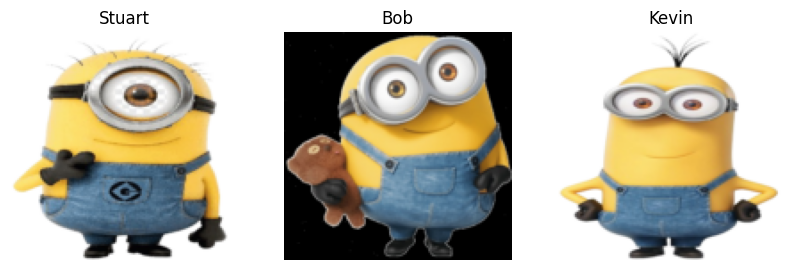

In [4]:

def collate_fn(batch):
    images = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch])
    return images, labels

dataloader = torch.utils.data.DataLoader(dataset, batch_size=3, shuffle=True, collate_fn=collate_fn)
images, labels = next(iter(dataloader))
class_names=['Bob','Kevin','Stuart']
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i in range(3):
    axes[i].imshow(images[i].permute(1, 2, 0))
    axes[i].set_title(class_names[labels[i]])
    axes[i].axis('off')
plt.show()

for i, image in enumerate(images):
    print(f"Shape of image {i+1}: {image.shape}")

Shape of image 1: torch.Size([3, 128, 128])
Shape of image 2: torch.Size([3, 128, 128])
Shape of image 3: torch.Size([3, 128, 128])


### 1.2. Load backgrounds

In order to train a custom object detection model, a dataset is needed. For this assignment, a synthetic dataset should be created by:

- **Inserting an object in a random position** on a background image.

**Therefore, collect a few background images from different locations** This can be done manually or via code.

It is recommended to use **icrawler** to automate the image collection process.


In [ ]:
!pip install icrawler

In [ ]:
!mkdir background

In case of any errors, try using a different crawler. You can use one of the following options:

```python
from icrawler.builtin import BaiduImageCrawler, BingImageCrawler, GoogleImageCrawler


In [ ]:
from icrawler.builtin import GoogleImageCrawler

google_crawler = GoogleImageCrawler(
    parser_threads=2,
    downloader_threads=4,
    storage={'root_dir': 'background'}
)

for keyword in ['budapest', 'budapest parliament', 'buda castle', 'budapest st stephen basilica', 'budapest heroes square']:
    google_crawler.crawl(
        keyword=keyword, max_num=10, file_idx_offset='auto')


2024-10-06 03:07:09,881 - INFO - icrawler.crawler - start crawling...
2024-10-06 03:07:09,881 - INFO - icrawler.crawler - starting 1 feeder threads...
2024-10-06 03:07:09,883 - INFO - feeder - thread feeder-001 exit
2024-10-06 03:07:09,885 - INFO - icrawler.crawler - starting 2 parser threads...
2024-10-06 03:07:09,887 - INFO - icrawler.crawler - starting 4 downloader threads...
2024-10-06 03:07:11,898 - INFO - parser - no more page urls for thread parser-002 to parse
2024-10-06 03:07:11,900 - INFO - parser - thread parser-002 exit
2024-10-06 03:07:14,896 - INFO - downloader - downloader-002 is waiting for new download tasks
2024-10-06 03:07:14,898 - INFO - downloader - downloader-001 is waiting for new download tasks
2024-10-06 03:07:14,898 - INFO - downloader - downloader-004 is waiting for new download tasks
2024-10-06 03:07:14,898 - INFO - downloader - downloader-003 is waiting for new download tasks
2024-10-06 03:07:15,866 - INFO - parser - parsing result page https://www.google.c

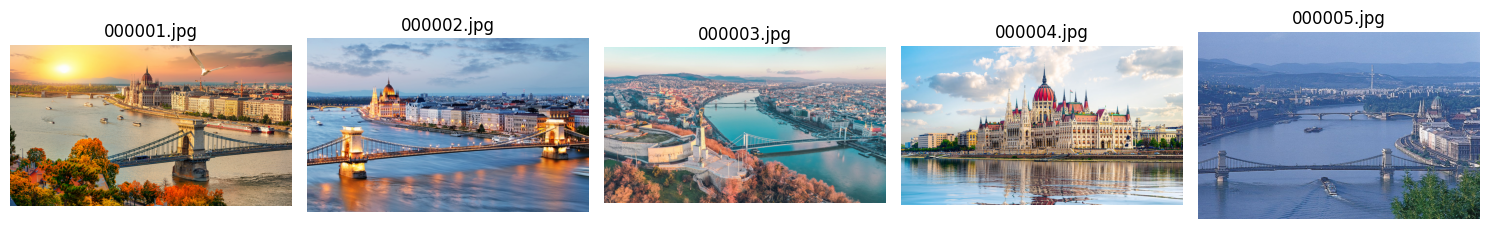

In [6]:
directory = 'background'

def display_sample_images(directory, num_images=5):
    image_files = [f for f in os.listdir(directory) if f.endswith(('jpg'))]

    num_images = min(num_images, len(image_files))

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    if num_images == 1:
        axes = [axes]

    for i in range(num_images):
        img_path = os.path.join(directory, image_files[i])
        image = mpimg.imread(img_path)
        axes[i].imshow(image)
        axes[i].set_title(image_files[i])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()



display_sample_images(directory)

### 1.3. Create dataset

### Dataset Creation

This is a crucial part of the assignment evaluation. From the selected objects and collected background images, follow these steps to generate your dataset:

1. **Randomly select background images** from your collection.
2. **Insert a single object** (from the three selected) into each background image at a **random location**.
3. **Record the object's coordinates** and create a corresponding bounding box. For example:
   - If an object with height `h` and width `w` is placed at position `(x, y)`, the bounding box should be in one of the following formats:
     - **[x, y, w, h]** or
     - **[x1, y1, x2, y2]**, where `x2 = x1 + w` and `y2 = y1 + h`.
4. If you plan to compare your custom model with a YOLO model, use the **YOLO bounding box format**:
   - `[(x + w/2)/image_width, (y + h/2)/image_height, w/image_width, h/image_height]`, where `image` refers to the background image dimensions.
5. **Save the generated dataset**, as it will be used for training your custom model and fine-tuning the existing object detection model.
6. **Wrap the dataset creation** in a **PyTorch Dataset class** for easier data handling and model training.
7. **Split the dataset** into training, validation, and test sets to evaluate your model effectively.


In [7]:
def createDataset(root_dir, background_dir='background', split='train', img_size=(640, 640), num_images=5000):
    split_dir = os.path.join(root_dir, split)
    images_dir = os.path.join(split_dir, 'images')
    labels_dir = os.path.join(split_dir, 'labels')

    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    background_images = [f for f in os.listdir(background_dir) if os.path.isfile(os.path.join(background_dir, f))]
    if not background_images:
        raise FileNotFoundError(f"No background images found in {background_dir}")

    object_dirs = [d for d in os.listdir('figures') if os.path.isdir(os.path.join('figures', d))]
    if not object_dirs:
        raise FileNotFoundError("No object directories found in 'figures'")

    class_map = {object_name: i for i, object_name in enumerate(object_dirs)}
    size_map = {object_name: random.randint(100, 150) for object_name in object_dirs}

    for i in range(num_images):
        bg_image_path = os.path.join(background_dir, random.choice(background_images))
        bg_image = Image.open(bg_image_path).convert('RGBA').resize(img_size)

        object_dir = random.choice(object_dirs)
        object_dir_path = os.path.join('figures', object_dir)
        object_images = [f for f in os.listdir(object_dir_path) if os.path.isfile(os.path.join(object_dir_path, f))]
        if not object_images:
            print(f"Warning: No images found in {object_dir_path}. Skipping...")
            continue

        object_image_path = random.choice(object_images)
        class_index = class_map[object_dir]
        object_size = size_map[object_dir]

        object_image = Image.open(os.path.join(object_dir_path, object_image_path)).convert('RGBA').resize((object_size, object_size))

        max_x = bg_image.width - object_image.width
        max_y = bg_image.height - object_image.height
        random_x = random.randint(0, max_x)
        random_y = random.randint(0, max_y)

        bg_image.paste(object_image, (random_x, random_y), object_image)

        image_filename = f'{i:05d}.png'
        image_path = os.path.join(images_dir, image_filename)
        bg_image.save(image_path)

        bbox_x = (random_x + object_size / 2) / bg_image.width
        bbox_y = (random_y + object_size / 2) / bg_image.height
        bbox_w = object_size / bg_image.width
        bbox_h = object_size / bg_image.height

        label_filename = f'{i:05d}.txt'
        label_path = os.path.join(labels_dir, label_filename)

        with open(label_path, 'w') as f:
            if class_index == -1:
                print(f"Warning: Class '{object_dir}' not found in class_map. Skipping...")
                continue

            f.write(f'{class_index} {bbox_x:.6f} {bbox_y:.6f} {bbox_w:.6f} {bbox_h:.6f}\n')

    print(f"Dataset creation completed for split: {split}. Images saved in {images_dir} and labels saved in {labels_dir}.")


createDataset('dataset', 'background', split='train', img_size=(640, 640), num_images=5000)
createDataset('dataset', 'background', split='val', img_size=(640, 640), num_images=1000)
createDataset('dataset', 'background', split='test', img_size=(640, 640), num_images=200)

Dataset creation completed for split: train. Images saved in dataset\train\images and labels saved in dataset\train\labels.
Dataset creation completed for split: val. Images saved in dataset\val\images and labels saved in dataset\val\labels.
Dataset creation completed for split: test. Images saved in dataset\test\images and labels saved in dataset\test\labels.


In [8]:
%pip install torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, root_dir, split='train', num_classes=3, transform=None):
        self.root_dir = root_dir
        self.split_dir = os.path.join(root_dir, split)
        self.image_dir = os.path.join(self.split_dir, 'images')
        self.label_dir = os.path.join(self.split_dir, 'labels')

        assert os.path.exists(self.image_dir), f"Image directory {self.image_dir} does not exist"
        assert os.path.exists(self.label_dir), f"Label directory {self.label_dir} does not exist"

        self.image_filenames = sorted(os.listdir(self.image_dir))
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace('.png', '.txt'))

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        with open(label_path, 'r') as f:
            bbox_list = []
            labels_list = []
            for line in f:
                label = line.strip().split()
                labels = int(label[0]) 
                bbox = [float(x) for x in label[1:]]
                labels_list.append(labels)
                bbox_list.append(bbox)

        return image, torch.tensor(labels_list[0]), torch.tensor(bbox_list)




In [5]:
root_dir = 'D:/Barnabas/Coding/dnd assignment/dataset'
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])

train_dataset = ObjectDetectionDataset(root_dir, split='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)

val_dataset = ObjectDetectionDataset(root_dir, split='val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

test_dataset = ObjectDetectionDataset(root_dir, split='test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

# Testing
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

for images, labels, bboxes in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels: {labels}")
    print(f"Batch of bounding boxes: {bboxes}")
    break 


Train dataset size: 5000
Validation dataset size: 1000
Test dataset size: 200
Batch of images shape: torch.Size([8, 3, 640, 640])
Batch of labels: tensor([0, 2, 2, 0, 2, 2, 1, 0])
Batch of bounding boxes: tensor([[[0.3008, 0.4680, 0.1641, 0.1641]],

        [[0.5758, 0.5992, 0.2109, 0.2109]],

        [[0.3430, 0.2117, 0.2109, 0.2109]],

        [[0.6086, 0.6117, 0.1641, 0.1641]],

        [[0.3305, 0.3242, 0.2109, 0.2109]],

        [[0.7398, 0.6320, 0.2109, 0.2109]],

        [[0.8227, 0.3758, 0.1922, 0.1922]],

        [[0.5633, 0.3789, 0.1641, 0.1641]]])


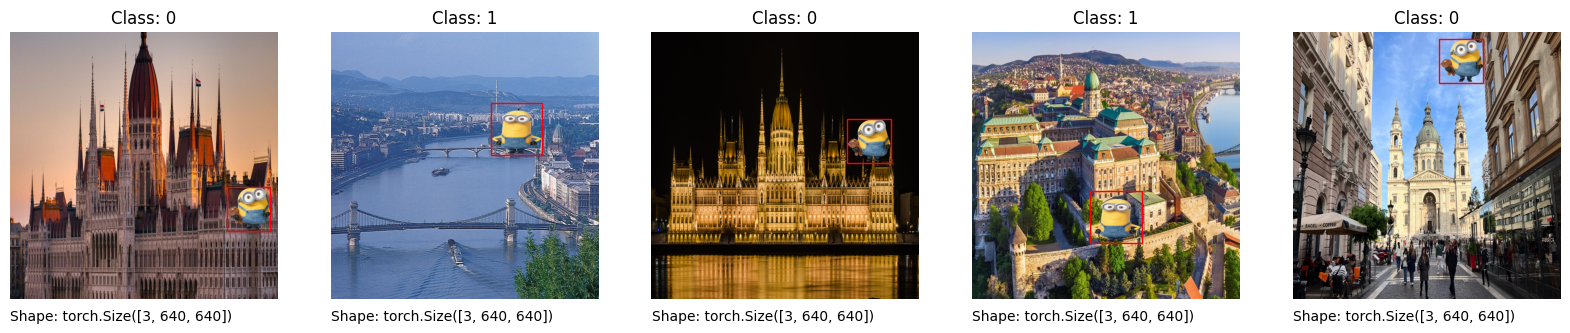

In [4]:
def visualize_dataset(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    random_indices = random.sample(range(len(dataset)), num_samples)
    for i, idx in enumerate(random_indices):
        image, labels, bbox_list = dataset[idx]
        axes[i].imshow(image.permute(1, 2, 0))

        for bbox_item in bbox_list:
            bbox_x, bbox_y, bbox_w, bbox_h = bbox_item.tolist()
            bbox_x *= image.shape[2]
            bbox_y *= image.shape[1]
            bbox_w *= image.shape[2]
            bbox_h *= image.shape[1]
            rect = patches.Rectangle((bbox_x - bbox_w / 2, bbox_y - bbox_h / 2), bbox_w, bbox_h, linewidth=1, edgecolor='r', facecolor='none')
            axes[i].add_patch(rect)

        axes[i].set_title(f'Class: {labels}')
        axes[i].axis('off')

        axes[i].text(0, image.shape[1] + 50, f'Shape: {image.shape}', fontsize=10, color='black')

    plt.show()

visualize_dataset(train_dataset, num_samples=5)


### 2. MODELS

In this assignment, you are tasked with building your own custom object detection model and comparing its performance against an existing object detection model.


### 2.1. Custom Object Detection model

### Create a Convolutional Neural Network (CNN) Architecture

Design a CNN-based architecture that includes a **backbone for feature extraction** and two output branches:

- One for **class probabilities** (with output size equal to the number of object classes, e.g., 3).
- Another for **bounding box regression** (with size 4 for the box coordinates: x, y, w, h, or in your chosen format).

This is the core evaluation of the assignment. Experiment with different layers, hyperparameters, and regularization techniques to optimize the model's performance.


In [9]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class CustomModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomModel, self).__init__()

        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )

        self.bbox_regressor = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        features = self.backbone(x)

        class_probs = self.classifier(features)
        bbox_regression = self.bbox_regressor(features)

        return class_probs, bbox_regression


In [11]:
dummy_image = torch.randn(1, 3, 640, 640).to(device)
num_classes = 3

model = CustomModel(num_classes).to(device)
cls_output, bbox_output = model(dummy_image)

print("Class Output Shape:", cls_output.shape)
print("Bounding Box Output Shape:", bbox_output.shape)

Class Output Shape: torch.Size([1, 3])
Bounding Box Output Shape: torch.Size([1, 4])


### 2.2. Train Your Model

Carefully choose key components like the **optimizer**, **loss function**, **number of epochs**, and **regularization techniques**. Ensure you're optimizing both **classification loss** and **bounding box regression loss**.

Monitor for signs of **overfitting** or **underfitting** by tracking how the loss evolves across epochs. The loss should consistently decrease as training progresses. Save and log these losses for visualization and further analysis.


**Example Plot**:

<a href="https://ibb.co/bzmMxJY"><img src="https://i.ibb.co/t8KTSXn/download.png" alt="download" border="0"></a>

In [8]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import torch.nn as nn

c:\Users\GamerBarny\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:1040: UserWarning: Using a target size (torch.Size([16, 1, 4])) that is different to the input size (torch.Size([16, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
c:\Users\GamerBarny\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:1040: UserWarning: Using a target size (torch.Size([8, 1, 4])) that is different to the input size (torch.Size([8, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Epoch [1/10], Train Loss: 1.1167, Val Loss: 1.1152
Epoch [2/10], Train Loss: 1.1129, Val Loss: 1.1119
Epoch [3/10], Train Loss: 1.1129, Val Loss: 1.1120
Epoch [4/10], Train Loss: 1.1121, Val Loss: 1.1111
Epoch [5/10], Train Loss: 1.0998, Val Loss: 1.0966
Epoch [6/10], Train Loss: 0.9382, Val Loss: 0.8548
Epoch [7/10], Train Loss: 0.7081, Val Loss: 0.7884
Epoch [8/10], Train Loss: 0.6273, Val Loss: 0.6002
Epoch [9/10], Train Loss: 0.5954, Val Loss: 0.5970
Epoch [10/10], Train Loss: 0.5823, Val Loss: 0.5699


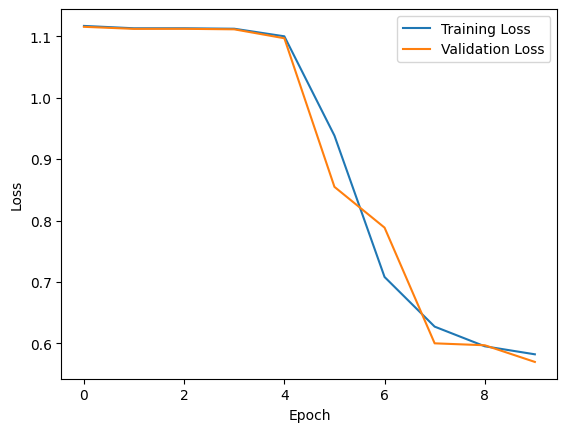

In [9]:
# Second own model attempt

import torch.optim as optim
import torch.nn as nn

optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Using Adam optimizer
class_loss_fn = nn.CrossEntropyLoss()  # For classification
bbox_loss_fn = nn.SmoothL1Loss()  # For bounding box regression

def train_model(model, train_loader, val_loader, optimizer, class_loss_fn, bbox_loss_fn, num_epochs=10):
    train_losses = []
    val_losses = []
    
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for images, class_labels, bboxes in train_loader:
            images = images.to(device)
            class_labels = class_labels.to(device)
            bboxes = bboxes.to(device)

            optimizer.zero_grad()

            class_outputs, bbox_outputs = model(images)

            class_loss = class_loss_fn(class_outputs, class_labels)
            bbox_loss = bbox_loss_fn(bbox_outputs, bboxes)

            total_loss = class_loss + bbox_loss

            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()
        
        train_losses.append(running_loss / len(train_loader))

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, class_labels, bboxes in val_loader:
                images = images.to(device)
                class_labels = class_labels.to(device)
                bboxes = bboxes.to(device)

                class_outputs, bbox_outputs = model(images)

                class_loss = class_loss_fn(class_outputs, class_labels)
                bbox_loss = bbox_loss_fn(bbox_outputs, bboxes)

                total_loss = class_loss + bbox_loss
                val_loss += total_loss.item()

        val_losses.append(val_loss / len(val_loader))
        model.train()

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    torch.save(model.state_dict(), 'custom_model_10_23.pth')
    torch.save({
        'train_losses': train_losses,
        'val_losses': val_losses
    }, 'training_data_10_23.pth')
    
    return train_losses, val_losses

import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, class_loss_fn, bbox_loss_fn, num_epochs=10)
plot_losses(train_losses, val_losses)



Epoch [1/10], Train Loss: 20.7515, Val Loss: 2.0929
Epoch [2/10], Train Loss: 2.0901, Val Loss: 2.0911
Epoch [3/10], Train Loss: 2.0895, Val Loss: 2.0908
Epoch [4/10], Train Loss: 2.0891, Val Loss: 2.0904
Epoch [5/10], Train Loss: 2.0892, Val Loss: 2.0911
Epoch [6/10], Train Loss: 2.0878, Val Loss: 2.0868
Epoch [7/10], Train Loss: -61541778848.0897, Val Loss: -1810588383712.0000
Epoch [8/10], Train Loss: -101700105518482.8125, Val Loss: -235093292687164.9375
Epoch [9/10], Train Loss: -1180192709788568.7500, Val Loss: -2528850635992763.0000
Epoch [10/10], Train Loss: -4923543243786001.0000, Val Loss: -7362600859501064.0000


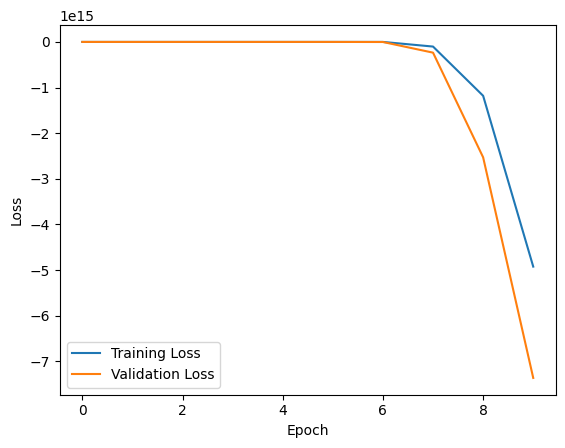

In [13]:
# third own model

import torch.optim as optim
import torch.nn as nn

def giou_loss(pred_bboxes, target_bboxes):
    x1_inter = torch.max(pred_bboxes[:, 0], target_bboxes[:, 0])
    y1_inter = torch.max(pred_bboxes[:, 1], target_bboxes[:, 1])
    x2_inter = torch.min(pred_bboxes[:, 2], target_bboxes[:, 2])
    y2_inter = torch.min(pred_bboxes[:, 3], target_bboxes[:, 3])
    
    inter_area = torch.clamp(x2_inter - x1_inter, min=0) * torch.clamp(y2_inter - y1_inter, min=0)
    pred_area = (pred_bboxes[:, 2] - pred_bboxes[:, 0]) * (pred_bboxes[:, 3] - pred_bboxes[:, 1])
    target_area = (target_bboxes[:, 2] - target_bboxes[:, 0]) * (target_bboxes[:, 3] - target_bboxes[:, 1])
    union_area = pred_area + target_area - inter_area
    
    iou = inter_area / torch.clamp(union_area, min=1e-6)
    x1_enclosing = torch.min(pred_bboxes[:, 0], target_bboxes[:, 0])
    y1_enclosing = torch.min(pred_bboxes[:, 1], target_bboxes[:, 1])
    x2_enclosing = torch.max(pred_bboxes[:, 2], target_bboxes[:, 2])
    y2_enclosing = torch.max(pred_bboxes[:, 3], target_bboxes[:, 3])
    enclosing_area = (x2_enclosing - x1_enclosing) * (y2_enclosing - y1_enclosing)
    
    giou = iou - (enclosing_area - union_area) / torch.clamp(enclosing_area, min=1e-6)

    return 1 - giou.mean()

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Using AdamW optimizer
class_loss_fn = nn.CrossEntropyLoss()  # For classification
bbox_loss_fn = giou_loss  # Use GIoU for bounding box regression

def train_model(model, train_loader, val_loader, optimizer, class_loss_fn, bbox_loss_fn, num_epochs=10):
    train_losses = []
    val_losses = []
    
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for images, class_labels, bboxes in train_loader:
            images = images.to(device)
            class_labels = class_labels.to(device)
            bboxes = bboxes.to(device)

            bboxes = bboxes.squeeze(1)

            optimizer.zero_grad()

            class_outputs, bbox_outputs = model(images)

            class_loss = class_loss_fn(class_outputs, class_labels)
            bbox_loss = bbox_loss_fn(bbox_outputs, bboxes)

            total_loss = class_loss + bbox_loss

            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()
        
        train_losses.append(running_loss / len(train_loader))

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, class_labels, bboxes in val_loader:
                images = images.to(device)
                class_labels = class_labels.to(device)
                bboxes = bboxes.to(device)

                bboxes = bboxes.squeeze(1)

                class_outputs, bbox_outputs = model(images)

                class_loss = class_loss_fn(class_outputs, class_labels)
                bbox_loss = bbox_loss_fn(bbox_outputs, bboxes)

                total_loss = class_loss + bbox_loss
                val_loss += total_loss.item()

        val_losses.append(val_loss / len(val_loader))
        model.train()

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    torch.save(model.state_dict(), 'custom_model_10_24.pth')
    torch.save({
        'train_losses': train_losses,
        'val_losses': val_losses
    }, 'training_data_10_24.pth')
    
    return train_losses, val_losses



import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, class_loss_fn, bbox_loss_fn, num_epochs=10)
plot_losses(train_losses, val_losses)


In [14]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

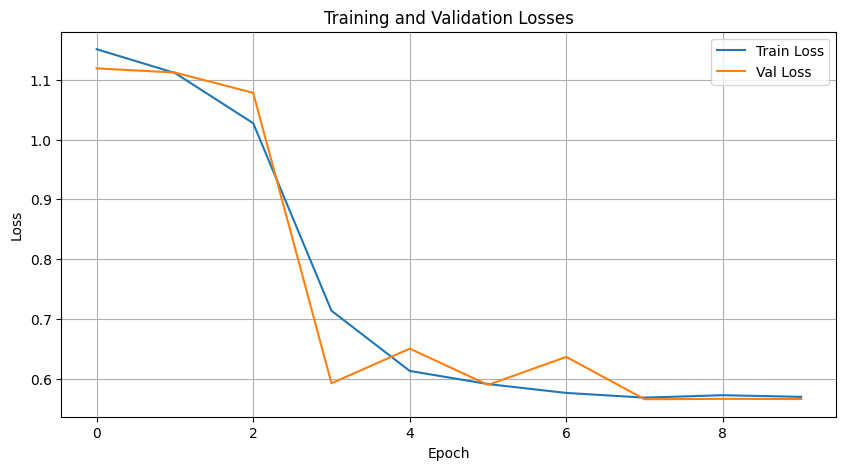

In [16]:
plot_losses(train_losses, val_losses)

### 2.3. Evaulate and do inference with the trained custom model

Choose **at least 3 metrics** to evaluate your object detection model. These could include:

- **Precision**: The proportion of correctly predicted positive instances (objects detected) out of all instances classified as positive.
- **Recall**: The proportion of correctly predicted positive instances out of all actual positive instances (objects present in the image).
- **F1-Score**: The harmonic mean of Precision and Recall, balancing false positives and false negatives.
- **IoU (Intersection over Union)**: Measures the overlap between the predicted bounding box and the ground truth bounding box.
- **mAP (mean Average Precision)**: This is one of the most common evaluation metrics for object detection. It averages precision at different recall thresholds across all object classes.
  
Additionally, you can assess:
- **Inference speed**: Time taken by the model to process a single image.
- **Number of parameters**: The total number of trainable parameters in the model.
- **Model size**: The disk size of the trained model.

### Show Performance Metric Visualizations

- Visualize the chosen metrics (e.g., **Precision, Recall, F1-Score, IoU, mAP**) over different epochs to demonstrate the improvement in the model’s performance.
- Plot losses (both classification loss and localization loss) to show how they decrease throughout training.

### Show Some Predictions of Your Trained Model

- Display sample images with **predicted bounding boxes** and compare them to the ground truth.
- Highlight the values of **Precision, Recall, IoU**, or other relevant metrics for each displayed prediction, giving a clear view of the model's performance.
  
You can also use **WandB (Weights and Biases)** or **TensorBoard** for more detailed logging and tracking of these metrics and visualizations.


In [ ]:
import torch

num_classes = 3
model_1 = CustomModel(num_classes=num_classes)

# Load the first model and set to evaluation mode
model_1.load_state_dict(torch.load('custom_model_10_23.pth'))
model_1.eval()  # Use model_1.eval() instead of model.eval()

# Load the second model and set to evaluation mode
model_2 = CustomModel(num_classes=num_classes)

model_2.load_state_dict(torch.load('custom_model_10_24.pth'))
model_2.eval()  # Use model_2.eval() instead of model.eval()


In [ ]:
%pip install torchmetrics


In [37]:
model = model_2
model.eval()

CustomModel(
  (backbone): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score
import torchmetrics
from torchmetrics.detection import IntersectionOverUnion, MeanAveragePrecision


def compute_metrics(pred_bboxes, true_bboxes, pred_classes, true_classes, num_classes):
    # Precision, Recall, F1 per class
    precision = precision_score(true_classes, pred_classes, average='macro', zero_division=0)
    recall = recall_score(true_classes, pred_classes, average='macro', zero_division=0)
    f1 = f1_score(true_classes, pred_classes, average='macro', zero_division=0)
    
    # IoU
    iou_metric = IntersectionOverUnion(num_classes=num_classes)
    iou = iou_metric(pred_bboxes, true_bboxes).item()
    
    # mAP
    map_metric = MeanAveragePrecision()
    map_value = map_metric(pred_bboxes, pred_classes, true_bboxes, true_classes)['map'].item()

    return precision, recall, f1, iou, map_value



def measure_inference_speed(model, dummy_input):
    model.eval()
    with torch.no_grad():
        start = time.time()
        _ = model(dummy_input)
        end = time.time()
    return end - start

def plot_metrics(metrics_dict, metric_names):
    for name in metric_names:
        plt.plot(metrics_dict[name], label=f'{name} over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.show()


def show_predictions(images, pred_bboxes, true_bboxes, pred_labels, true_labels):
    for i in range(len(images)):
        fig, ax = plt.subplots(1)
        ax.imshow(images[i].cpu().permute(1, 2, 0))

        for bbox, label in zip(pred_bboxes[i], pred_labels[i]):
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(bbox[0], bbox[1], f'Pred: {label}', color='red', fontsize=12)

        for bbox, label in zip(true_bboxes[i], true_labels[i]):
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            ax.text(bbox[0], bbox[1], f'True: {label}', color='green', fontsize=12)

        plt.show()


In [38]:
from sklearn.metrics import precision_score, recall_score, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

def evaluate_test_set(model, test_loader,device):
    model.eval()
    all_predictions = []
    all_targets = []
    all_bbox_preds = []
    all_bbox_targets = []
    with torch.no_grad():
        for image, labels, bbox_list in test_loader:
            image = image.to(device)
            labels = labels.to(device)
            bbox_list = bbox_list.to(device)
            class_probs, bbox_regression = model(image)
            _, predicted = torch.max(class_probs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            all_bbox_preds.extend(bbox_regression.cpu().numpy())
            all_bbox_targets.extend(bbox_list.cpu().numpy())
    precision = precision_score(all_targets, all_predictions, average='macro', zero_division=1)
    recall = recall_score(all_targets, all_predictions, average='macro')
    all_targets_binary = label_binarize(all_targets, classes=np.unique(all_targets))
    all_predictions_binary = label_binarize(all_predictions, classes=np.unique(all_predictions))
    mAP = roc_auc_score(all_targets_binary, all_predictions_binary, average='macro', multi_class='ovr')
    return precision, recall, mAP

precision, recall, mAP = evaluate_test_set(model, test_loader, device)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, mAP: {mAP:.4f}')

Precision: 0.8000, Recall: 0.3333, mAP: 0.5000


In [39]:
dummy_image = torch.randn(1, 3, 640, 640).to(device)
inference_time = measure_inference_speed(model, dummy_image)
print(f"Inference Time (sec): {inference_time:.4f}")

num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of Parameters: {num_parameters}")

torch.save(model.state_dict(), 'temp_model.pth')
model_size_mb = os.path.getsize('temp_model.pth') / 1e6
os.remove('temp_model.pth')
print(f"Model Size (MB): {model_size_mb:.2f}")


Inference Time (sec): 0.3490
Number of Parameters: 980359
Model Size (MB): 3.94


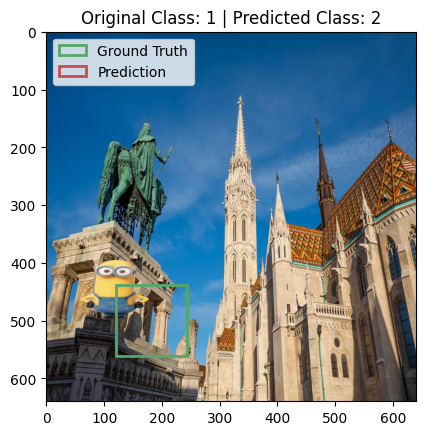

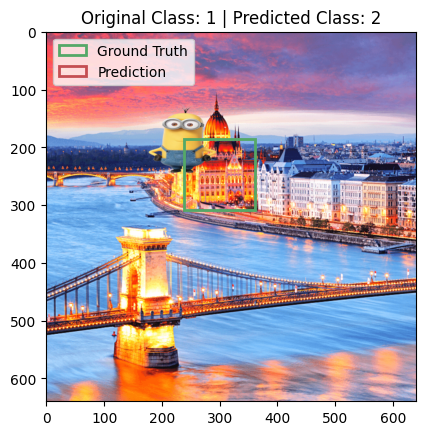

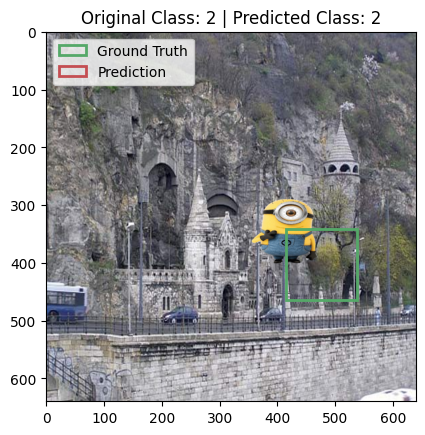

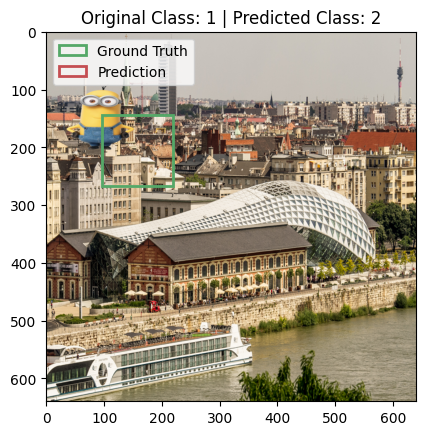

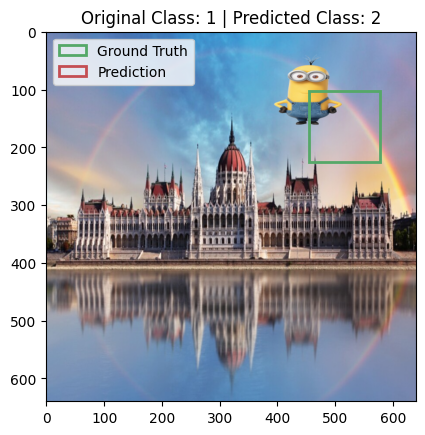

In [48]:
import torchvision.transforms as T
from matplotlib.patches import Rectangle

def visualize_predictions(model, test_dataset, num_images=5):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    inv_transform = T.ToPILImage()

    for i in range(num_images):
        image, true_label, true_bbox = test_dataset[i]

        image = image.unsqueeze(0).to(device)
        true_bbox = true_bbox.to(device)

        with torch.no_grad():
            class_probs, pred_bbox = model(image)
            pred_label = torch.argmax(class_probs, dim=1).item()
            pred_bbox = pred_bbox.squeeze(0).cpu().numpy()

        img_width, img_height = image.shape[3], image.shape[2]

        pred_bbox_xcenter, pred_bbox_ycenter, pred_bbox_width, pred_bbox_height = pred_bbox
        
        pred_bbox_xmin = pred_bbox_xcenter - (pred_bbox_width / 2)
        pred_bbox_ymin = pred_bbox_ycenter - (pred_bbox_height / 2)

        pred_bbox_xmin *= img_width
        pred_bbox_ymin *= img_height
        pred_bbox_width *= img_width
        pred_bbox_height *= img_height

        image_np = inv_transform(image.squeeze(0).cpu())

        fig, ax = plt.subplots(1)
        ax.imshow(image_np)

        gt_bbox = true_bbox.squeeze(0).cpu().numpy()
        gt_bbox_xmin = gt_bbox[0] * img_width
        gt_bbox_ymin = gt_bbox[1] * img_height
        gt_bbox_width = gt_bbox[2] * img_width
        gt_bbox_height = gt_bbox[3] * img_height

        gt_rect = Rectangle((gt_bbox_xmin, gt_bbox_ymin), gt_bbox_width, gt_bbox_height, 
                            linewidth=2, edgecolor='g', facecolor='none', label="Ground Truth")
        ax.add_patch(gt_rect)

        pred_rect = Rectangle((pred_bbox_xmin, pred_bbox_ymin), pred_bbox_width, pred_bbox_height, 
                              linewidth=2, edgecolor='r', facecolor='none', label="Prediction")
        ax.add_patch(pred_rect)

        ax.set_title(f"Original Class: {true_label} | Predicted Class: {pred_label}")
        ax.legend(loc="upper left")
        plt.show()

visualize_predictions(model, test_dataset)


In [50]:
custom_model = model_2

### 2.4. Load an Existing Object Detection Model

We recommend using the latest **YOLO** version, but you are free to choose any other **PyTorch-based** object detection model.


In [ ]:
%pip install ultralytics

In [15]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

New https://pypi.org/project/ultralytics/8.3.21 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.18  Python-3.12.4 torch-2.5.0+cpu CPU (Intel Core(TM) i5-4440 3.10GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:/Barnabas/Coding/dnd assignment/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train16, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, s

train: Scanning D:\Barnabas\Coding\dnd assignment\dataset\train\labels.cache... 5000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]
val: Scanning D:\Barnabas\Coding\dnd assignment\dataset\val\labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


Plotting labels to runs\detect\train16\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train16
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G     0.4982      1.576     0.8685          8        640: 100%|██████████| 313/313 [40:33<00:00,  7.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [03:04<00:00,  5.75s/it]


                   all       1000       1000      0.999          1      0.995      0.953

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G     0.3375     0.5797     0.8108          8        640: 100%|██████████| 313/313 [37:25<00:00,  7.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [03:03<00:00,  5.74s/it]

                   all       1000       1000          1          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      0.293     0.3585      0.806          7        640: 100%|██████████| 313/313 [37:20<00:00,  7.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [03:01<00:00,  5.67s/it]

                   all       1000       1000          1          1      0.995      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G     0.2413     0.2685     0.8007          8        640: 100%|██████████| 313/313 [37:54<00:00,  7.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [03:15<00:00,  6.10s/it]

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G     0.2085     0.2251     0.7949          8        640: 100%|██████████| 313/313 [38:02<00:00,  7.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [03:01<00:00,  5.66s/it]

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G     0.1838     0.1946     0.7892          8        640: 100%|██████████| 313/313 [37:43<00:00,  7.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [03:01<00:00,  5.66s/it]

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G     0.1569      0.169     0.7869          8        640: 100%|██████████| 313/313 [37:42<00:00,  7.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [03:17<00:00,  6.18s/it]

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.1365     0.1426     0.7799          8        640: 100%|██████████| 313/313 [38:09<00:00,  7.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [03:08<00:00,  5.90s/it]

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G     0.1177     0.1279     0.7799          8        640: 100%|██████████| 313/313 [38:21<00:00,  7.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [03:03<00:00,  5.72s/it]

                   all       1000       1000          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.1015     0.1117     0.7789          8        640: 100%|██████████| 313/313 [37:51<00:00,  7.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [03:03<00:00,  5.75s/it]

                   all       1000       1000          1          1      0.995      0.995



10 epochs completed in 6.878 hours.
Optimizer stripped from runs\detect\train16\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train16\weights\best.pt, 6.2MB

Validating runs\detect\train16\weights\best.pt...
Ultralytics 8.3.18  Python-3.12.4 torch-2.5.0+cpu CPU (Intel Core(TM) i5-4440 3.10GHz)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [02:37<00:00,  4.91s/it]


                   all       1000       1000          1          1      0.995      0.995
                   Bob        326        326          1          1      0.995      0.995
                 Kevin        345        345          1          1      0.995      0.995
                Stuart        329        329          1          1      0.995      0.995
Speed: 3.9ms preprocess, 134.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\train16


### 2.5. Fine-tune the existing object detection model
If you choose to use **YOLO**, training the model can be done easily by providing a `data.yaml` file (which follows a specific format, check the official GitHub repository for details) and running the training script.

For example, you can run YOLO from the command line with:

```bash
!yolo task=detect mode=train data=datasets/data.yaml model=yolov8n.yaml epochs=200 imgsz=640
```

Make sure to show the losses and metrics visualizations. By default, YOLO should **verbose** those.

In [ ]:

model.train(data='D:/Barnabas/Coding/dnd assignment/data.yaml', epochs=10, imgsz=640)

model.save('D:/Barnabas/Coding/dnd assignment/yolo_model2.pt')

### 2.6 Evaluate the existing object detection model
**Compare the performance** of your custom model and the YOLO model, ensuring both are evaluated on the **same subset of images** using the **same metrics** chosen in **Step 2.3** (e.g., Precision, Recall, F1-Score, IoU, mAP).


In [17]:
model = YOLO('D:/Barnabas/Coding/dnd assignment/yolo_model2.pt')

results = model.val(data='D:/Barnabas/Coding/dnd assignment/data.yaml')

# Print the evaluation metrics (mAP@0.5, mAP@0.5:0.95, precision, recall)
print(f"mAP@0.5: {results.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP@0.5:0.95: {results.results_dict['metrics/mAP50-95(B)']:.4f}")
print(f"Precision: {results.results_dict['metrics/precision(B)']:.4f}")
print(f"Recall: {results.results_dict['metrics/recall(B)']:.4f}")


Ultralytics 8.3.18  Python-3.12.4 torch-2.5.0+cpu CPU (Intel Core(TM) i5-4440 3.10GHz)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\Barnabas\Coding\dnd assignment\dataset\val\labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [03:44<00:00,  3.56s/it]


                   all       1000       1000          1          1      0.995      0.995
                   Bob        326        326          1          1      0.995      0.995
                 Kevin        345        345          1          1      0.995      0.995
                Stuart        329        329          1          1      0.995      0.995
Speed: 4.6ms preprocess, 185.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\val5
mAP@0.5: 0.9950
mAP@0.5:0.95: 0.9950
Precision: 0.9998
Recall: 1.0000


# 3. COMPARISON
**Compare the performance** of your custom model and the YOLO model, ensuring both are evaluated on the **same subset of images** for a fair comparison. Key metrics to include:

- **Precision**
- **Recall**
- **F1-Score**
- **IoU (Intersection over Union)**
- **mAP (mean Average Precision)**

### Visualize Predictions

- Show predictions from both models on the same images.
- Include bounding boxes, class labels, and relevant metrics like IoU or Precision.

### Explain Differences

- Discuss why one model may perform better than the other, considering architecture, dataset complexity, or fine-tuning.

### Improve Custom Model

- Suggest improvements such as better data augmentation, model architecture adjustments, hyperparameter tuning, or more training data.
- Explore **Transfer Learning**, **learning rate scheduling**, or new optimizers for better performance.


In [53]:
def evaluate_yolo_model(yolo_model_path, data_yaml_path):
    model = YOLO(yolo_model_path)

    results = model.val(data=data_yaml_path)

    # Extract evaluation metrics
    precision = results.results_dict['metrics/precision(B)']
    recall = results.results_dict['metrics/recall(B)']
    mAP = results.results_dict['metrics/mAP50(B)']

    return precision, recall, mAP

yolo_precision, yolo_recall, yolo_mAP = evaluate_yolo_model('D:/Barnabas/Coding/dnd assignment/yolo_model2.pt', 'D:/Barnabas/Coding/dnd assignment/data.yaml')


Ultralytics 8.3.18  Python-3.12.4 torch-2.5.0+cpu CPU (Intel Core(TM) i5-4440 3.10GHz)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\Barnabas\Coding\dnd assignment\dataset\val\labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [02:58<00:00,  2.84s/it]


                   all       1000       1000          1          1      0.995      0.995
                   Bob        326        326          1          1      0.995      0.995
                 Kevin        345        345          1          1      0.995      0.995
                Stuart        329        329          1          1      0.995      0.995
Speed: 3.7ms preprocess, 151.9ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\detect\val6


In [55]:
custom_precision, custom_recall, custom_mAP = evaluate_test_set(custom_model, test_loader, device)


In [56]:
def compare_models(yolo_precision, yolo_recall, yolo_mAP, custom_precision, custom_recall, custom_mAP):
    print("Comparison of YOLOv8 Model and Custom Model:")
    print(f"{'Metric':<15}{'YOLOv8':<15}{'Custom Model':<15}")
    print(f"{'-'*45}")
    print(f"{'Precision':<15}{yolo_precision:<15.4f}{custom_precision:<15.4f}")
    print(f"{'Recall':<15}{yolo_recall:<15.4f}{custom_recall:<15.4f}")
    print(f"{'mAP@0.5':<15}{yolo_mAP:<15.4f}{custom_mAP:<15.4f}")

compare_models(yolo_precision, yolo_recall, yolo_mAP, custom_precision, custom_recall, custom_mAP)


Comparison of YOLOv8 Model and Custom Model:
Metric         YOLOv8         Custom Model   
---------------------------------------------
Precision      0.9998         0.8000         
Recall         1.0000         0.3333         
mAP@0.5        0.9950         0.5000         



image 1/200 D:\Barnabas\Coding\dnd assignment\dataset\test\images\00000.png: 640x640 1 Kevin, 190.0ms
image 2/200 D:\Barnabas\Coding\dnd assignment\dataset\test\images\00001.png: 640x640 1 Kevin, 174.0ms
image 3/200 D:\Barnabas\Coding\dnd assignment\dataset\test\images\00002.png: 640x640 1 Stuart, 159.0ms
image 4/200 D:\Barnabas\Coding\dnd assignment\dataset\test\images\00003.png: 640x640 1 Kevin, 153.0ms
image 5/200 D:\Barnabas\Coding\dnd assignment\dataset\test\images\00004.png: 640x640 1 Kevin, 164.0ms
image 6/200 D:\Barnabas\Coding\dnd assignment\dataset\test\images\00005.png: 640x640 1 Stuart, 160.0ms
image 7/200 D:\Barnabas\Coding\dnd assignment\dataset\test\images\00006.png: 640x640 1 Stuart, 146.0ms
image 8/200 D:\Barnabas\Coding\dnd assignment\dataset\test\images\00007.png: 640x640 1 Stuart, 129.0ms
image 9/200 D:\Barnabas\Coding\dnd assignment\dataset\test\images\00008.png: 640x640 1 Bob, 145.0ms
image 10/200 D:\Barnabas\Coding\dnd assignment\dataset\test\images\00009.png: 6

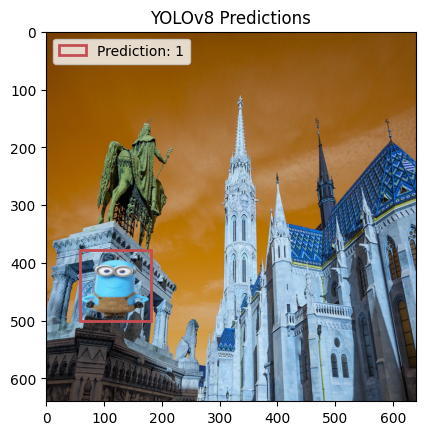

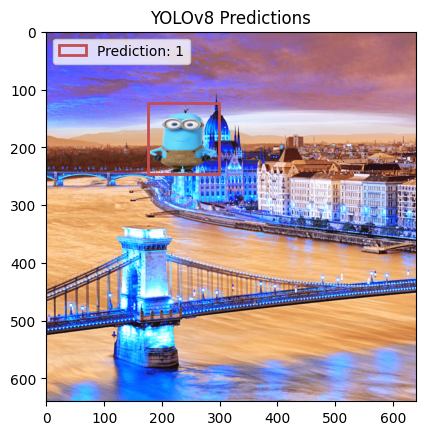

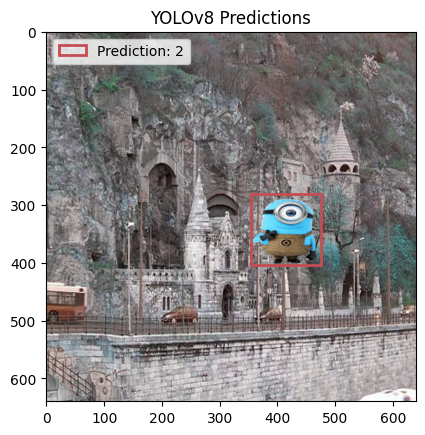

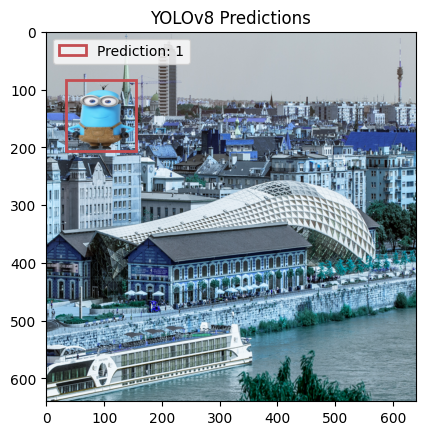

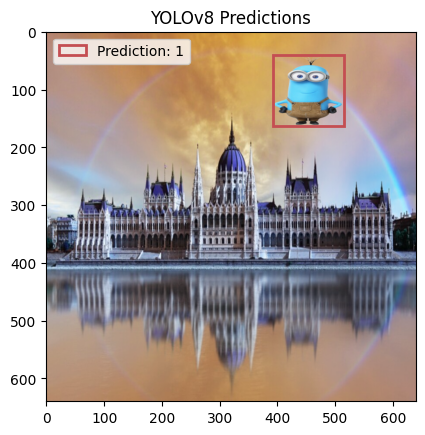

In [65]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from ultralytics import YOLO

model_yolo = YOLO('D:/Barnabas/Coding/dnd assignment/yolo_model2.pt')

test_images_path = 'D:/Barnabas/Coding/dnd assignment/dataset/test/images'

results = model_yolo.predict(source=test_images_path, save=False, conf=0.25)

def visualize_yolo_predictions(yolo_results, num_images=5):
    for i, result in enumerate(yolo_results):
        if i >= num_images:
            break

        image = result.orig_img
        img_width, img_height = image.shape[1], image.shape[0]

        fig, ax = plt.subplots(1)
        ax.imshow(image)

        for pred_box, pred_class in zip(result.boxes.xyxy.cpu().numpy(), result.boxes.cls.cpu().numpy()):
            pred_bbox_xmin = pred_box[0]
            pred_bbox_ymin = pred_box[1]
            pred_bbox_xmax = pred_box[2]
            pred_bbox_ymax = pred_box[3]

            pred_bbox_width = pred_bbox_xmax - pred_bbox_xmin
            pred_bbox_height = pred_bbox_ymax - pred_bbox_ymin

            pred_rect = Rectangle((pred_bbox_xmin, pred_bbox_ymin), pred_bbox_width, pred_bbox_height, 
                                  linewidth=2, edgecolor='r', facecolor='none', label=f"Prediction: {int(pred_class)}")
            ax.add_patch(pred_rect)

        ax.set_title("YOLOv8 Predictions")
        ax.legend(loc="upper left")
        plt.show()

visualize_yolo_predictions(results, num_images=5)


**Discuss why one model may perform better than the other, considering architecture, dataset complexity, or fine-tuning**:

### 1. **Architecture**
- **YOLOv8**: Designed for object detection with a highly optimized architecture. It uses advanced techniques like anchor-based detection and non-maximum suppression for accurate object localization.
- **Custom Model**: Likely simpler in design, lacking the same multi-scale feature extraction and post-processing optimizations. This may result in less precise or slower predictions.

### 2. **Dataset Complexity**
- **YOLOv8**: Pre-trained on large datasets like COCO, allowing it to generalize well, even with limited training on your custom dataset. Its transfer learning capabilities enable it to handle complex images and varied object types effectively.
- **Custom Model**: If trained only on your custom dataset, it may overfit due to lack of exposure to diverse data. A smaller, less diverse dataset could make it harder for the model to generalize, leading to lower performance on unseen images.

### 3. **Fine-Tuning**
- **YOLOv8**: Benefits from years of hyperparameter tuning, data augmentation, and learning rate optimization, making it more robust across datasets. Its built-in augmentations help improve generalization and detection under varied conditions.
- **Custom Model**: Depending on training and hyperparameter optimization, it may not be as well-tuned. If trained from scratch without extensive augmentation or fine-tuning, it could suffer from underfitting or overfitting, affecting detection accuracy.

### Summary
YOLOv8 may perform better due to its optimized architecture, transfer learning from large datasets, and extensive fine-tuning. Your custom model, while potentially simpler, might require more data, augmentation, and tuning to match YOLO's performance.


### Improve Custom Model

To enhance the performance of my custom model, I would consider the following improvements:

### 1. **Model Architecture Adjustments**
- **Add more convolutional layers**: Deepening the model could help in capturing more complex features, especially in images with multiple objects.
- **Incorporate multi-scale feature extraction**: Techniques like **FPN (Feature Pyramid Network)** or **PANet** can help the model better detect objects at various scales.
- **Use Residual Connections**: Adding skip connections (as seen in ResNet or YOLOv8) can improve gradient flow during training, helping the model learn more efficiently.

### 2. **Data Augmentation**
- **Increase data diversity**: Apply advanced augmentations like random scaling, rotations, color jittering, and flipping to make the model more robust against variations in object size, orientation, and lighting.

### 3. **Transfer Learning**
- **Leverage pre-trained models**: Start from a pre-trained model on a large dataset (e.g., ImageNet or COCO) and fine-tune it on your custom dataset. This will help the model learn generalized features from a large corpus of images before adapting to your specific task.

### 4. **Training Data**
- **Increase dataset size**: Larger datasets with varying object orientations and backgrounds will improve generalization.


I thoroughly enjoyed working on this assignment; however, I couldn't implement as many features as I had hoped. Some model experiments took up to 12 hours to run, which limited my time for additional improvements. Fortunately, with remote access to my powerful setup at home, I was able to accomplish much more than I would have been able to on my laptop alone.